# importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

In [2]:
# To display full facts

pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv('train.csv', encoding='utf-8')
df.head()

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana. During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union. Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation. Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.” Thompson then appealed to the Supreme Court of Louisiana. That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true. Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant. \n",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,"Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed. The U.S. Court of Appeals for the Seventh Circuit reversed the denial and held that the trial judge’s inference about Owens’s motive violated his right to have his guilt adjudicated solely based on the evidence presented at trial.\n",0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.","An Alabama state court convicted Billy Joe Magwood of murder and sentenced him to death. Subsequently, an Alabama federal district court partially granted Mr. Magwood's petition for federal habeas corpus relief. The court upheld his conviction but instructed the state court to look at mitigating evidence when resentencing Mr. Magwood. Upon resentencing, the state court sentenced Mr. Magwood to death once again. Mr. Magwood filed a second petition for federal habeas corpus relief with the federal district court arguing that a judicial rule was retroactively applied in his case and that he lacked effective counsel at sentencing. The district court granted the petition and vacated Mr. Magwood's death sentence.\nOn appeal, the U.S. Court of Appeals for the Eleventh circuit reversed, holding that prisoners may not raise challenges to an original sentence that could have been raised in an earlier petition. The court also held that Mr. Magwood's counsel was not ineffective because he failed to raise an argument that had already been decided by the state's highest court adverse to his client's position.\n",1
3,TRAIN_0003,Linkletter,Walker,"Victor Linkletter was convicted in state court on evidence illegally obtained by police prior to the Supreme Court decision concerning the Fourth Amendment in Mapp v. Ohio. Mapp applied the exclusionary rule to state criminal proceedings, denying the use of illegally obtained evidence at trial. Linkletter argued for a retrial based on the Mapp decision.\n"

In [4]:
print(f'There are {len(df)} cases.')

There are 2478 cases.


In [5]:
# To check types of columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [6]:
# To check missing values in the dataset

df.isna().sum()

ID                    0
first_party           0
second_party          0
facts                 0
first_party_winner    0
dtype: int64

# statistics

In [7]:
# facts의 평균 알파벳수
avg_char = df['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average number of characters in facts: {avg_char}')

# 1의 자리로 표현
print(f'Average number of characters in facts: {avg_char:.0f}')

# facts의 평균 단어수
avg_word = df['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average number of words in facts: {avg_word}')

# 1의 자리로 표현
print(f'Average number of words in facts: {avg_word:.0f}')

# del함수 = 오브젝트 내용 삭제
del avg_char, avg_word

Average number of characters in facts: 1109.0564971751412
Average number of characters in facts: 1109
Average number of words in facts: 173.90153349475383
Average number of words in facts: 174


In [8]:
# facts의 알파벳 스탯
df['facts'].apply(lambda x: len(str(x))).describe()

count    2478.000000
mean     1109.056497
std       515.510744
min        15.000000
25%       771.250000
50%      1048.000000
75%      1373.750000
max      5795.000000
Name: facts, dtype: float64

In [9]:
# facts의 단어 스탯
df['facts'].apply(lambda x: len(str(x).split())).describe()

count    2478.000000
mean      173.901533
std        82.177924
min         2.000000
25%       120.000000
50%       164.000000
75%       217.750000
max       932.000000
Name: facts, dtype: float64

# data processing

In [10]:
plt_name = []
defd_name = []
for i in range(df.shape[0]):
    fact = df['facts'][i]
    plaintiff = df['first_party'][i]
    defendant = df['second_party'][i]
    p = True
    d = True
    for _ in plaintiff.split():
        if _ in fact:
            p = True
            break
        else:
            p = False
    if p == False:
        plt_name.append(i)
    for _ in defendant.split():
        if _ in fact:
            d = True
            break
        else:
            d = False
    if d == False:
        defd_name.append(i)

In [11]:
per_missing_plt = len(plt_name) / len(df) * 100
print('percentage of missing plaintiff\'s name: {:.2f}%'.format(per_missing_plt))

per_missing_defd = len(defd_name) / len(df) * 100
print('percentage of missing defendant\'s name: {:.2f}%'.format(per_missing_defd))

per_missing_both = len(set(set(plt_name) & set(defd_name))) / len(df) * 100
print('percentage of missing both party\'s name: {:.2f}%'.format(per_missing_both))

percentage of missing plaintiff's name: 16.34%
percentage of missing defendant's name: 18.97%
percentage of missing both party's name: 3.31%


# imbalance in label class

first_party_winner
1    1649
0     829
Name: count, dtype: int64


<Axes: ylabel='Type'>

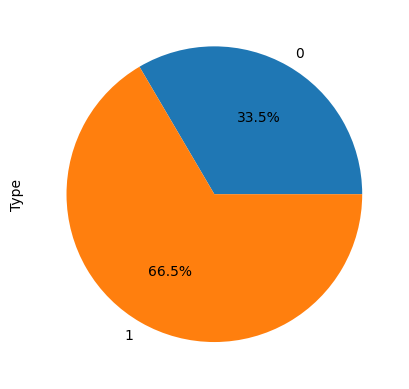

In [12]:
print(df['first_party_winner'].value_counts())

df.groupby('first_party_winner').size().plot(kind = 'pie', 
                                             y = 'first_party_winner',
                                             label = 'Type',
                                             autopct = '%1.1f%%'
                                            )

# TTS

In [13]:
X_train, X_test, y_train, y_test = \
train_test_split(df[['first_party_winner', 'facts']],
                df['first_party_winner'],
                test_size = 0.2,
                stratify = df['first_party_winner'],
                random_state = 0
                )

In [14]:
plaintiff = X_train[X_train['first_party_winner'] == 0]
defendant = X_train[X_train['first_party_winner'] == 1]
print(plaintiff.shape)
print(defendant.shape)

(663, 2)
(1319, 2)


# Upsampling train data

In [15]:
from sklearn.utils import resample
upsample_defendant = resample(defendant,
                              replace = True,
                              n_samples = len(plaintiff),
                               random_state = 0
                              )

first_party_winner
1    663
0    663
Name: count, dtype: int64


<Axes: ylabel='Type'>

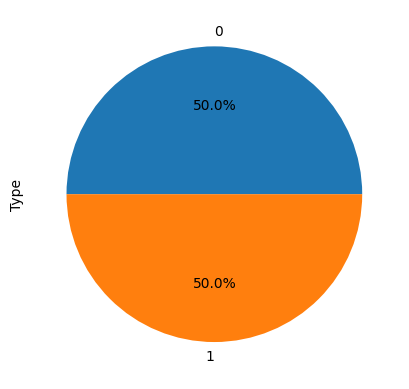

In [16]:
upsample_train = pd.concat([upsample_defendant, plaintiff])

print(upsample_train['first_party_winner'].value_counts())

upsample_train.groupby('first_party_winner').size().plot(kind = 'pie',
                                                        y = 'first_party_winner',
                                                        label = 'Type',
                                                        autopct = '%1.1f%%'
                                                        )

In [17]:
# shuffle dataset

shuffled_data = np.arange(upsample_train.shape[0])
np.random.shuffle(shuffled_data)

In [18]:
shuffled_train = upsample_train.iloc[shuffled_data,:]

X_train = shuffled_train['facts']
y_train = shuffled_train['first_party_winner']

In [19]:
X_test = X_test['facts']

# Simple neural network

In [20]:
# tokenizer 모델 정의

def nltk_tokenizer(_wd):
    return RegexpTokenizer(r'\w+').tokenize(_wd.lower())

In [21]:
# X data를 데이터프레임 형식으로 변환

X_train_frame = X_train.to_frame()
X_test_frame = X_test.to_frame()

# tokenize facts
X_train_frame['tokenized_facts'] = X_train_frame['facts'].apply(nltk_tokenizer)
X_test_frame['tokenized_facts'] = X_test_frame['facts'].apply(nltk_tokenizer)

# Doc2Vec 모델을 사용하기위한 형식 변경
tokens_train = X_train_frame['tokenized_facts'].to_list()
docs_train = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_train)]
tokens_test = X_test_frame['tokenized_facts'].to_list()
docs_test = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_test)]

In [22]:
# doc2vec 모델 설정하기

doc2vec_model = Doc2Vec(vector_size = 50, min_count = 2, epochs = 40, dm = 1, seed = 0)
doc2vec_model.build_vocab(docs_train)
doc2vec_model.train(docs_train, total_examples = doc2vec_model.corpus_count, epochs = doc2vec_model.epochs)

In [23]:
# 학습, 평가 데이터셋 벡터화 시키기

X_train_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_train]
X_train_dvs = pd.DataFrame(X_train_dvs, index = X_train.index)

X_test_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_test]
X_test_dvs = pd.DataFrame(X_test_dvs, index = X_test.index)

In [24]:
# Dense layer model 정의

def simple_model():
    model = keras.Sequential([
        layers.Dropout(0,3),
        layers.BatchNormalization(),      
        layers.Dense(200, activation="relu", kernel_regularizer="l1"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(100, activation="relu", kernel_regularizer="l1"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(50, activation="relu"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        layers.Dense(20, activation="relu"),
        layers.Dropout(0.4),
        layers.BatchNormalization(),      
        layers.Dense(1, activation="sigmoid"),
        ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [25]:
# 학습 및 검증

k = 4
num_validation_samples = len(X_train_dvs) // k
EPOCHS = 30
BATCH_SIZE = 50
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# 각 검쯩 폴드 마다, 전체 학습 및 이력 저장

for fold in range(k):
    validation_data = X_train_dvs[num_validation_samples * fold:
                          num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                         num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train_dvs[:num_validation_samples * fold],
        X_train_dvs[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    
    model_2 = simple_model()
    history_2 = model_2.fit(training_data, training_targets, 
                            validation_data = (validation_data, validation_targets),
                           epochs = EPOCHS, batch_size = BATCH_SIZE)
    
    val_loss_history_2 = history_2.history['val_loss']
    val_acc_history_2 = history_2.history['val_accuracy']
    loss_history_2 = history_2.history['loss']
    acc_history_2 = history_2.history['accuracy']
    all_val_loss_histories.append(val_loss_history_2)
    all_loss_histories.append(loss_history_2)
    all_val_acc_histories.append(val_acc_history_2)
    all_acc_histories.append(acc_history_2)
    
avg_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(EPOCHS)]
avg_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(EPOCHS)]
avg_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(EPOCHS)]
avg_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(EPOCHS)]

Epoch 1/30
20/20 [==============================] - 2s 44ms/step - loss: 20.1752 - accuracy: 0.5146 - val_loss: 17.3445 - val_accuracy: 0.4804
Epoch 2/30
20/20 [==============================] - 0s 17ms/step - loss: 15.2308 - accuracy: 0.5156 - val_loss: 12.8174 - val_accuracy: 0.5196
Epoch 3/30
20/20 [==============================] - 0s 17ms/step - loss: 11.0985 - accuracy: 0.4955 - val_loss: 9.0799 - val_accuracy: 0.5408
Epoch 4/30
20/20 [==============================] - 0s 16ms/step - loss: 7.7010 - accuracy: 0.4915 - val_loss: 6.0890 - val_accuracy: 0.5287
Epoch 5/30
20/20 [==============================] - 0s 16ms/step - loss: 5.0311 - accuracy: 0.5106 - val_loss: 3.8494 - val_accuracy: 0.5650
Epoch 6/30
20/20 [==============================] - 0s 16ms/step - loss: 3.1753 - accuracy: 0.4945 - val_loss: 2.3966 - val_accuracy: 0.5498
Epoch 7/30
20/20 [==============================] - 0s 16ms/step - loss: 1.9977 - accuracy: 0.5548 - val_loss: 1.6228 - val_accuracy: 0.5619
Epoch 8/

Epoch 29/30
20/20 [==============================] - 0s 15ms/step - loss: 0.8379 - accuracy: 0.5276 - val_loss: 0.8242 - val_accuracy: 0.5921
Epoch 30/30
20/20 [==============================] - 0s 15ms/step - loss: 0.8291 - accuracy: 0.5206 - val_loss: 0.8131 - val_accuracy: 0.5770
Epoch 1/30
20/20 [==============================] - 2s 38ms/step - loss: 20.2565 - accuracy: 0.4935 - val_loss: 17.3943 - val_accuracy: 0.5166
Epoch 2/30
20/20 [==============================] - 0s 16ms/step - loss: 15.3446 - accuracy: 0.5116 - val_loss: 12.9436 - val_accuracy: 0.5257
Epoch 3/30
20/20 [==============================] - 0s 16ms/step - loss: 11.2616 - accuracy: 0.5106 - val_loss: 9.2388 - val_accuracy: 0.5438
Epoch 4/30
20/20 [==============================] - 0s 15ms/step - loss: 7.8793 - accuracy: 0.5196 - val_loss: 6.2788 - val_accuracy: 0.5589
Epoch 5/30
20/20 [==============================] - 0s 16ms/step - loss: 5.2568 - accuracy: 0.5196 - val_loss: 4.0501 - val_accuracy: 0.4864
Epoch 

Epoch 27/30
20/20 [==============================] - 0s 15ms/step - loss: 0.8505 - accuracy: 0.5266 - val_loss: 0.8491 - val_accuracy: 0.5438
Epoch 28/30
20/20 [==============================] - 0s 15ms/step - loss: 0.8555 - accuracy: 0.5337 - val_loss: 0.8460 - val_accuracy: 0.4955
Epoch 29/30
20/20 [==============================] - 0s 16ms/step - loss: 0.8339 - accuracy: 0.5658 - val_loss: 0.8333 - val_accuracy: 0.5347
Epoch 30/30
20/20 [==============================] - 0s 15ms/step - loss: 0.8408 - accuracy: 0.5417 - val_loss: 0.8368 - val_accuracy: 0.5498


In [26]:
# keras.utils.plot_model(model_1,show_shapes=True)

In [27]:
np.mean(avg_val_acc_history)

0.5112285976608594

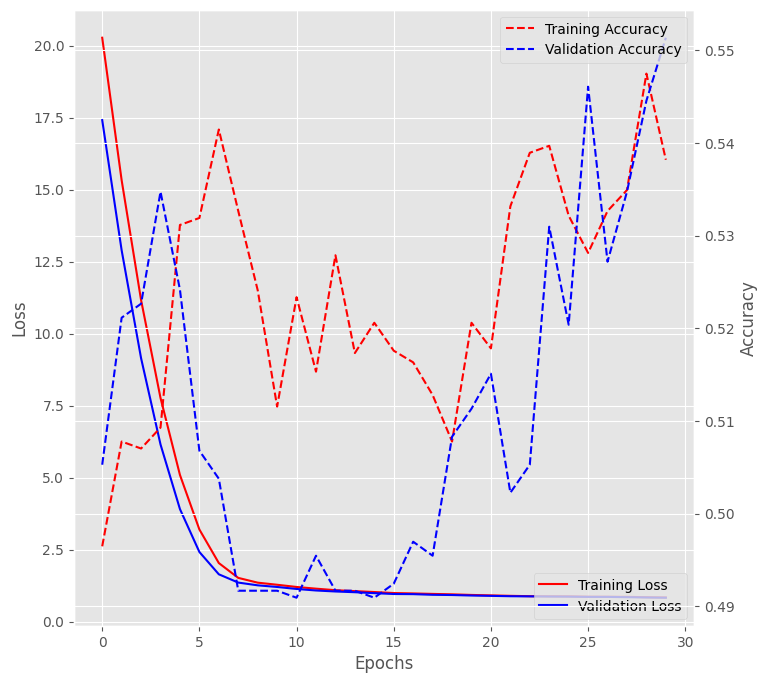

In [28]:
# plot loss and accuracy on train, validation data

plt.style.use('ggplot')

fig, ax=plt.subplots(figsize=(8,8))
ax.plot(avg_loss_history,c='r', label="Training Loss")
ax.plot(avg_val_loss_history,c='b', label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(['Training Loss','Validation Loss'], loc="lower right")

ax2=ax.twinx()
ax2.plot(avg_acc_history,c="r",linestyle="dashed", label="Training Accuracy")
ax2.plot(avg_val_acc_history,c='b',linestyle="dashed", label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"], loc="upper right")

plt.show()

16/16 [==============================] - 0s 6ms/step


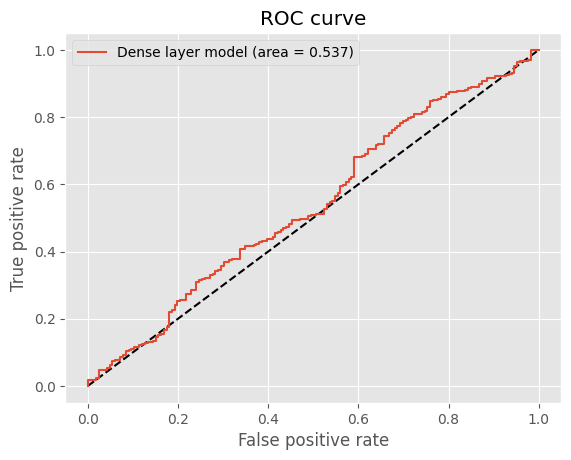

In [29]:
from sklearn.metrics import roc_curve
y_pred_2 = model_2.predict(X_test_dvs).ravel()
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_2)

from sklearn.metrics import auc
auc_1 = auc(fpr_1, tpr_1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Dense layer model (area = {:.3f})'.format(auc_1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [30]:
# evaluate the model by using test data
loss_metrics = model_1.evaluate(X_test_dvs,y_test,verbose=1)

NameError: name 'model_1' is not defined